In [9]:
import pandas as pd
import numpy as np
import os
import random
import cv2
from math import sqrt, floor
from prettytable import PrettyTable
from tqdm.notebook import tqdm_notebook
import time


# Helper functions

# segment disease area from leaf

In [13]:
def segmentDisease(img):
    hsv_img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2HSV)
    lower_bound= (14, 28, 0)
    upper_bound= (30, 200, 255)


    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    seg_sb10_img = cv2.bitwise_and(img, img, mask=mask)
    return seg_sb10_img

# segment leaf from background

In [14]:
# plant area segmentation
def segmentLeaf(img):
    hsv_img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2HSV)
    lower_bound= (24, 50, 0)
    upper_bound= (55, 255, 255)

    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    seg_sb10_img = cv2.bitwise_and(img, img, mask=mask)
    return seg_sb10_img, mask

# detect leaf and disease areas in image

In [15]:

# detect leaf and disease areas in image
def detect_objects(image):
    # Convert Image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a Mask with adaptive threshold
    mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 19, 5)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    objects_contours = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 2000:
            objects_contours.append(cnt)

    return objects_contours


# find orientation of disease and leaf in image

In [16]:
def findOrientation(contours):
    if contours:
        #get rectangle of first contour object
        rect = cv2.minAreaRect(contours[0])

        #extract properties from rect
        (x, y), (w,h), angle = rect 

        #display rectangle
    #     box = cv2.boxPoints(rect)
    #     box = np.int0(box)
    #     box_img = cv2.drawContours(sb10_seg, [box], 0, (255, 0, 0), 2)
        return angle,x,y
    else:
        return 0,0,0


# Rotate input image

In [17]:
def rotateImage(image, angle):
    center=tuple(np.array(image.shape[0:2])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    return cv2.warpAffine(image, rot_mat, image.shape[0:2],flags=cv2.INTER_LINEAR)

# https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point

In [ ]:
985 images


# Generate synthetic image

In [23]:
def createSyntheticImages(diseasePath, leafPath, newDestPath):
    for disease in tqdm_notebook(os.listdir(diseasePath), desc = 'Progress Disease'):
        dis_img_path = os.path.join(diseasePath, disease)
        orig_dis_img = cv2.imread(dis_img_path)
        seg_dis_img = segmentDisease(orig_dis_img)
        cont_seg_dis_img = detect_objects(seg_dis_img)
        dAng, dx, dy = findOrientation(cont_seg_dis_img)
        rota_seg_dis_img = rotateImage(seg_dis_img, dAng)


        for leaf in tqdm_notebook(os.listdir(leafPath), desc = 'Progress leaf'):


            print(f"disease no {disease} sb no {leaf}")
            image_path = os.path.join(leafPath, leaf)
            orig_image= cv2.imread(image_path)
            orig_image = cv2.resize(orig_image, (256,256))
            seg_image, seg_image_mask = segmentLeaf(orig_image)
            cont_seg_image = detect_objects(seg_image)
            lAng, lx, ly = findOrientation(cont_seg_image)
            rota_seg_image = rotateImage(seg_image, lAng)
            rota_seg_image_mask = rotateImage(seg_image_mask, lAng)


            # create ROI 
            rows,cols,channels = seg_dis_img.shape
            roi = rota_seg_image[0:rows, 0:cols]

            # use leaf to extract to draw out disease area
            img2_fg = cv2.bitwise_and(rota_seg_dis_img,rota_seg_dis_img,mask = rota_seg_image_mask)

            # Now create a mask of disease and create its inverse mask also
            seg_dis_img2gray = cv2.cvtColor(img2_fg,cv2.COLOR_BGR2GRAY)
            ret, seg_dis_mask = cv2.threshold(seg_dis_img2gray, 10, 255, cv2.THRESH_BINARY)
            seg_dis_mask_inv = cv2.bitwise_not(seg_dis_mask)
            img1_bg = cv2.bitwise_and(roi,roi,mask = seg_dis_mask_inv)
            syn_img = cv2.add(img1_bg,img2_fg)

            # generate classification label
            fname_l, _ =os.path.splitext(os.path.basename(image_path))
            fname_d, _ =os.path.splitext(os.path.basename(dis_img_path))


            cv2.imwrite(os.path.join(newDestPath, ''.join([ 'cgls_', fname_d ,'_', 'sb_', fname_l,'.png'])), syn_img)
    return 'done'

# Randomly choose and move disease image

In [19]:
syn_input_folder = 'models_data/totally_new/corn_seg'
syn_dest_folder = 'models_data/totally_new/10_corn_seg'

In [20]:
random.seed(42)
for i in range(88):
    random_image = random.choice(os.listdir(syn_input_folder))
    
    rand_img_path = os.path.join(syn_input_folder, random_image)
    dest_path = os.path.join(syn_dest_folder, random_image)
    os.rename(rand_img_path, dest_path)
    print(rand_img_path, dest_path)

models_data/totally_new/corn_seg/337.jpg models_data/totally_new/10_corn_seg/337.jpg
models_data/totally_new/corn_seg/58.jpg models_data/totally_new/10_corn_seg/58.jpg
models_data/totally_new/corn_seg/13.jpg models_data/totally_new/10_corn_seg/13.jpg
models_data/totally_new/corn_seg/392.jpg models_data/totally_new/10_corn_seg/392.jpg
models_data/totally_new/corn_seg/148.jpg models_data/totally_new/10_corn_seg/148.jpg
models_data/totally_new/corn_seg/132.jpg models_data/totally_new/10_corn_seg/132.jpg
models_data/totally_new/corn_seg/121.jpg models_data/totally_new/10_corn_seg/121.jpg
models_data/totally_new/corn_seg/75.jpg models_data/totally_new/10_corn_seg/75.jpg
models_data/totally_new/corn_seg/395.jpg models_data/totally_new/10_corn_seg/395.jpg
models_data/totally_new/corn_seg/54.jpg models_data/totally_new/10_corn_seg/54.jpg
models_data/totally_new/corn_seg/364.jpg models_data/totally_new/10_corn_seg/364.jpg
models_data/totally_new/corn_seg/400.jpg models_data/totally_new/10_corn_

In [22]:
leafPath = 'models_data/totally_new/10_seg_sb'
diseasePath = 'models_data/totally_new/100_corn_seg'
newDestPath = 'models_data/totally_new/1k_syn_sb'

len(os.listdir(leafPath)), len(os.listdir(diseasePath))

(10, 100)

# run generate function

In [24]:
createSyntheticImages(diseasePath, leafPath, newDestPath)

Progress Disease:   0%|          | 0/100 [00:00<?, ?it/s]

Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 1.jpg sb no 109.png
disease no 1.jpg sb no 115.png
disease no 1.jpg sb no 141.png
disease no 1.jpg sb no 145.png
disease no 1.jpg sb no 227.png
disease no 1.jpg sb no 248.png
disease no 1.jpg sb no 253.png
disease no 1.jpg sb no 342.png
disease no 1.jpg sb no 411.png
disease no 1.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 102.jpg sb no 109.png
disease no 102.jpg sb no 115.png
disease no 102.jpg sb no 141.png
disease no 102.jpg sb no 145.png
disease no 102.jpg sb no 227.png
disease no 102.jpg sb no 248.png
disease no 102.jpg sb no 253.png
disease no 102.jpg sb no 342.png
disease no 102.jpg sb no 411.png
disease no 102.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 106.jpg sb no 109.png
disease no 106.jpg sb no 115.png
disease no 106.jpg sb no 141.png
disease no 106.jpg sb no 145.png
disease no 106.jpg sb no 227.png
disease no 106.jpg sb no 248.png
disease no 106.jpg sb no 253.png
disease no 106.jpg sb no 342.png
disease no 106.jpg sb no 411.png
disease no 106.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 147.jpg sb no 109.png
disease no 147.jpg sb no 115.png
disease no 147.jpg sb no 141.png
disease no 147.jpg sb no 145.png
disease no 147.jpg sb no 227.png
disease no 147.jpg sb no 248.png
disease no 147.jpg sb no 253.png
disease no 147.jpg sb no 342.png
disease no 147.jpg sb no 411.png
disease no 147.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 210.jpg sb no 109.png
disease no 210.jpg sb no 115.png
disease no 210.jpg sb no 141.png
disease no 210.jpg sb no 145.png
disease no 210.jpg sb no 227.png
disease no 210.jpg sb no 248.png
disease no 210.jpg sb no 253.png
disease no 210.jpg sb no 342.png
disease no 210.jpg sb no 411.png
disease no 210.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 298.jpg sb no 109.png
disease no 298.jpg sb no 115.png
disease no 298.jpg sb no 141.png
disease no 298.jpg sb no 145.png
disease no 298.jpg sb no 227.png
disease no 298.jpg sb no 248.png
disease no 298.jpg sb no 253.png
disease no 298.jpg sb no 342.png
disease no 298.jpg sb no 411.png
disease no 298.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 476.jpg sb no 109.png
disease no 476.jpg sb no 115.png
disease no 476.jpg sb no 141.png
disease no 476.jpg sb no 145.png
disease no 476.jpg sb no 227.png
disease no 476.jpg sb no 248.png
disease no 476.jpg sb no 253.png
disease no 476.jpg sb no 342.png
disease no 476.jpg sb no 411.png
disease no 476.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 496.jpg sb no 109.png
disease no 496.jpg sb no 115.png
disease no 496.jpg sb no 141.png
disease no 496.jpg sb no 145.png
disease no 496.jpg sb no 227.png
disease no 496.jpg sb no 248.png
disease no 496.jpg sb no 253.png
disease no 496.jpg sb no 342.png
disease no 496.jpg sb no 411.png
disease no 496.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 63.jpg sb no 109.png
disease no 63.jpg sb no 115.png
disease no 63.jpg sb no 141.png
disease no 63.jpg sb no 145.png
disease no 63.jpg sb no 227.png
disease no 63.jpg sb no 248.png
disease no 63.jpg sb no 253.png
disease no 63.jpg sb no 342.png
disease no 63.jpg sb no 411.png
disease no 63.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 86.jpg sb no 109.png
disease no 86.jpg sb no 115.png
disease no 86.jpg sb no 141.png
disease no 86.jpg sb no 145.png
disease no 86.jpg sb no 227.png
disease no 86.jpg sb no 248.png
disease no 86.jpg sb no 253.png
disease no 86.jpg sb no 342.png
disease no 86.jpg sb no 411.png
disease no 86.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 179.jpg sb no 109.png
disease no 179.jpg sb no 115.png
disease no 179.jpg sb no 141.png
disease no 179.jpg sb no 145.png
disease no 179.jpg sb no 227.png
disease no 179.jpg sb no 248.png
disease no 179.jpg sb no 253.png
disease no 179.jpg sb no 342.png
disease no 179.jpg sb no 411.png
disease no 179.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 272.jpg sb no 109.png
disease no 272.jpg sb no 115.png
disease no 272.jpg sb no 141.png
disease no 272.jpg sb no 145.png
disease no 272.jpg sb no 227.png
disease no 272.jpg sb no 248.png
disease no 272.jpg sb no 253.png
disease no 272.jpg sb no 342.png
disease no 272.jpg sb no 411.png
disease no 272.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 337.jpg sb no 109.png
disease no 337.jpg sb no 115.png
disease no 337.jpg sb no 141.png
disease no 337.jpg sb no 145.png
disease no 337.jpg sb no 227.png
disease no 337.jpg sb no 248.png
disease no 337.jpg sb no 253.png
disease no 337.jpg sb no 342.png
disease no 337.jpg sb no 411.png
disease no 337.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 58.jpg sb no 109.png
disease no 58.jpg sb no 115.png
disease no 58.jpg sb no 141.png
disease no 58.jpg sb no 145.png
disease no 58.jpg sb no 227.png
disease no 58.jpg sb no 248.png
disease no 58.jpg sb no 253.png
disease no 58.jpg sb no 342.png
disease no 58.jpg sb no 411.png
disease no 58.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 13.jpg sb no 109.png
disease no 13.jpg sb no 115.png
disease no 13.jpg sb no 141.png
disease no 13.jpg sb no 145.png
disease no 13.jpg sb no 227.png
disease no 13.jpg sb no 248.png
disease no 13.jpg sb no 253.png
disease no 13.jpg sb no 342.png
disease no 13.jpg sb no 411.png
disease no 13.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 392.jpg sb no 109.png
disease no 392.jpg sb no 115.png
disease no 392.jpg sb no 141.png
disease no 392.jpg sb no 145.png
disease no 392.jpg sb no 227.png
disease no 392.jpg sb no 248.png
disease no 392.jpg sb no 253.png
disease no 392.jpg sb no 342.png
disease no 392.jpg sb no 411.png
disease no 392.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 148.jpg sb no 109.png
disease no 148.jpg sb no 115.png
disease no 148.jpg sb no 141.png
disease no 148.jpg sb no 145.png
disease no 148.jpg sb no 227.png
disease no 148.jpg sb no 248.png
disease no 148.jpg sb no 253.png
disease no 148.jpg sb no 342.png
disease no 148.jpg sb no 411.png
disease no 148.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 132.jpg sb no 109.png
disease no 132.jpg sb no 115.png
disease no 132.jpg sb no 141.png
disease no 132.jpg sb no 145.png
disease no 132.jpg sb no 227.png
disease no 132.jpg sb no 248.png
disease no 132.jpg sb no 253.png
disease no 132.jpg sb no 342.png
disease no 132.jpg sb no 411.png
disease no 132.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 121.jpg sb no 109.png
disease no 121.jpg sb no 115.png
disease no 121.jpg sb no 141.png
disease no 121.jpg sb no 145.png
disease no 121.jpg sb no 227.png
disease no 121.jpg sb no 248.png
disease no 121.jpg sb no 253.png
disease no 121.jpg sb no 342.png
disease no 121.jpg sb no 411.png
disease no 121.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 75.jpg sb no 109.png
disease no 75.jpg sb no 115.png
disease no 75.jpg sb no 141.png
disease no 75.jpg sb no 145.png
disease no 75.jpg sb no 227.png
disease no 75.jpg sb no 248.png
disease no 75.jpg sb no 253.png
disease no 75.jpg sb no 342.png
disease no 75.jpg sb no 411.png
disease no 75.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 395.jpg sb no 109.png
disease no 395.jpg sb no 115.png
disease no 395.jpg sb no 141.png
disease no 395.jpg sb no 145.png
disease no 395.jpg sb no 227.png
disease no 395.jpg sb no 248.png
disease no 395.jpg sb no 253.png
disease no 395.jpg sb no 342.png
disease no 395.jpg sb no 411.png
disease no 395.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 54.jpg sb no 109.png
disease no 54.jpg sb no 115.png
disease no 54.jpg sb no 141.png
disease no 54.jpg sb no 145.png
disease no 54.jpg sb no 227.png
disease no 54.jpg sb no 248.png
disease no 54.jpg sb no 253.png
disease no 54.jpg sb no 342.png
disease no 54.jpg sb no 411.png
disease no 54.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 364.jpg sb no 109.png
disease no 364.jpg sb no 115.png
disease no 364.jpg sb no 141.png
disease no 364.jpg sb no 145.png
disease no 364.jpg sb no 227.png
disease no 364.jpg sb no 248.png
disease no 364.jpg sb no 253.png
disease no 364.jpg sb no 342.png
disease no 364.jpg sb no 411.png
disease no 364.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 400.jpg sb no 109.png
disease no 400.jpg sb no 115.png
disease no 400.jpg sb no 141.png
disease no 400.jpg sb no 145.png
disease no 400.jpg sb no 227.png
disease no 400.jpg sb no 248.png
disease no 400.jpg sb no 253.png
disease no 400.jpg sb no 342.png
disease no 400.jpg sb no 411.png
disease no 400.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 479.jpg sb no 109.png
disease no 479.jpg sb no 115.png
disease no 479.jpg sb no 141.png
disease no 479.jpg sb no 145.png
disease no 479.jpg sb no 227.png
disease no 479.jpg sb no 248.png
disease no 479.jpg sb no 253.png
disease no 479.jpg sb no 342.png
disease no 479.jpg sb no 411.png
disease no 479.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 295.jpg sb no 109.png
disease no 295.jpg sb no 115.png
disease no 295.jpg sb no 141.png
disease no 295.jpg sb no 145.png
disease no 295.jpg sb no 227.png
disease no 295.jpg sb no 248.png
disease no 295.jpg sb no 253.png
disease no 295.jpg sb no 342.png
disease no 295.jpg sb no 411.png
disease no 295.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 46.jpg sb no 109.png
disease no 46.jpg sb no 115.png
disease no 46.jpg sb no 141.png
disease no 46.jpg sb no 145.png
disease no 46.jpg sb no 227.png
disease no 46.jpg sb no 248.png
disease no 46.jpg sb no 253.png
disease no 46.jpg sb no 342.png
disease no 46.jpg sb no 411.png
disease no 46.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 321.jpg sb no 109.png
disease no 321.jpg sb no 115.png
disease no 321.jpg sb no 141.png
disease no 321.jpg sb no 145.png
disease no 321.jpg sb no 227.png
disease no 321.jpg sb no 248.png
disease no 321.jpg sb no 253.png
disease no 321.jpg sb no 342.png
disease no 321.jpg sb no 411.png
disease no 321.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 232.jpg sb no 109.png
disease no 232.jpg sb no 115.png
disease no 232.jpg sb no 141.png
disease no 232.jpg sb no 145.png
disease no 232.jpg sb no 227.png
disease no 232.jpg sb no 248.png
disease no 232.jpg sb no 253.png
disease no 232.jpg sb no 342.png
disease no 232.jpg sb no 411.png
disease no 232.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 18.jpg sb no 109.png
disease no 18.jpg sb no 115.png
disease no 18.jpg sb no 141.png
disease no 18.jpg sb no 145.png
disease no 18.jpg sb no 227.png
disease no 18.jpg sb no 248.png
disease no 18.jpg sb no 253.png
disease no 18.jpg sb no 342.png
disease no 18.jpg sb no 411.png
disease no 18.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 17.jpg sb no 109.png
disease no 17.jpg sb no 115.png
disease no 17.jpg sb no 141.png
disease no 17.jpg sb no 145.png
disease no 17.jpg sb no 227.png
disease no 17.jpg sb no 248.png
disease no 17.jpg sb no 253.png
disease no 17.jpg sb no 342.png
disease no 17.jpg sb no 411.png
disease no 17.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 52.jpg sb no 109.png
disease no 52.jpg sb no 115.png
disease no 52.jpg sb no 141.png
disease no 52.jpg sb no 145.png
disease no 52.jpg sb no 227.png
disease no 52.jpg sb no 248.png
disease no 52.jpg sb no 253.png
disease no 52.jpg sb no 342.png
disease no 52.jpg sb no 411.png
disease no 52.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 125.jpg sb no 109.png
disease no 125.jpg sb no 115.png
disease no 125.jpg sb no 141.png
disease no 125.jpg sb no 145.png
disease no 125.jpg sb no 227.png
disease no 125.jpg sb no 248.png
disease no 125.jpg sb no 253.png
disease no 125.jpg sb no 342.png
disease no 125.jpg sb no 411.png
disease no 125.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 135.jpg sb no 109.png
disease no 135.jpg sb no 115.png
disease no 135.jpg sb no 141.png
disease no 135.jpg sb no 145.png
disease no 135.jpg sb no 227.png
disease no 135.jpg sb no 248.png
disease no 135.jpg sb no 253.png
disease no 135.jpg sb no 342.png
disease no 135.jpg sb no 411.png
disease no 135.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 281.jpg sb no 109.png
disease no 281.jpg sb no 115.png
disease no 281.jpg sb no 141.png
disease no 281.jpg sb no 145.png
disease no 281.jpg sb no 227.png
disease no 281.jpg sb no 248.png
disease no 281.jpg sb no 253.png
disease no 281.jpg sb no 342.png
disease no 281.jpg sb no 411.png
disease no 281.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 335.jpg sb no 109.png
disease no 335.jpg sb no 115.png
disease no 335.jpg sb no 141.png
disease no 335.jpg sb no 145.png
disease no 335.jpg sb no 227.png
disease no 335.jpg sb no 248.png
disease no 335.jpg sb no 253.png
disease no 335.jpg sb no 342.png
disease no 335.jpg sb no 411.png
disease no 335.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 15.jpg sb no 109.png
disease no 15.jpg sb no 115.png
disease no 15.jpg sb no 141.png
disease no 15.jpg sb no 145.png
disease no 15.jpg sb no 227.png
disease no 15.jpg sb no 248.png
disease no 15.jpg sb no 253.png
disease no 15.jpg sb no 342.png
disease no 15.jpg sb no 411.png
disease no 15.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 314.jpg sb no 109.png
disease no 314.jpg sb no 115.png
disease no 314.jpg sb no 141.png
disease no 314.jpg sb no 145.png
disease no 314.jpg sb no 227.png
disease no 314.jpg sb no 248.png
disease no 314.jpg sb no 253.png
disease no 314.jpg sb no 342.png
disease no 314.jpg sb no 411.png
disease no 314.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 115.jpg sb no 109.png
disease no 115.jpg sb no 115.png
disease no 115.jpg sb no 141.png
disease no 115.jpg sb no 145.png
disease no 115.jpg sb no 227.png
disease no 115.jpg sb no 248.png
disease no 115.jpg sb no 253.png
disease no 115.jpg sb no 342.png
disease no 115.jpg sb no 411.png
disease no 115.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 402.jpg sb no 109.png
disease no 402.jpg sb no 115.png
disease no 402.jpg sb no 141.png
disease no 402.jpg sb no 145.png
disease no 402.jpg sb no 227.png
disease no 402.jpg sb no 248.png
disease no 402.jpg sb no 253.png
disease no 402.jpg sb no 342.png
disease no 402.jpg sb no 411.png
disease no 402.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 365.jpg sb no 109.png
disease no 365.jpg sb no 115.png
disease no 365.jpg sb no 141.png
disease no 365.jpg sb no 145.png
disease no 365.jpg sb no 227.png
disease no 365.jpg sb no 248.png
disease no 365.jpg sb no 253.png
disease no 365.jpg sb no 342.png
disease no 365.jpg sb no 411.png
disease no 365.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 394.jpg sb no 109.png
disease no 394.jpg sb no 115.png
disease no 394.jpg sb no 141.png
disease no 394.jpg sb no 145.png
disease no 394.jpg sb no 227.png
disease no 394.jpg sb no 248.png
disease no 394.jpg sb no 253.png
disease no 394.jpg sb no 342.png
disease no 394.jpg sb no 411.png
disease no 394.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 307.jpg sb no 109.png
disease no 307.jpg sb no 115.png
disease no 307.jpg sb no 141.png
disease no 307.jpg sb no 145.png
disease no 307.jpg sb no 227.png
disease no 307.jpg sb no 248.png
disease no 307.jpg sb no 253.png
disease no 307.jpg sb no 342.png
disease no 307.jpg sb no 411.png
disease no 307.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 238.jpg sb no 109.png
disease no 238.jpg sb no 115.png
disease no 238.jpg sb no 141.png
disease no 238.jpg sb no 145.png
disease no 238.jpg sb no 227.png
disease no 238.jpg sb no 248.png
disease no 238.jpg sb no 253.png
disease no 238.jpg sb no 342.png
disease no 238.jpg sb no 411.png
disease no 238.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 129.jpg sb no 109.png
disease no 129.jpg sb no 115.png
disease no 129.jpg sb no 141.png
disease no 129.jpg sb no 145.png
disease no 129.jpg sb no 227.png
disease no 129.jpg sb no 248.png
disease no 129.jpg sb no 253.png
disease no 129.jpg sb no 342.png
disease no 129.jpg sb no 411.png
disease no 129.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 255.jpg sb no 109.png
disease no 255.jpg sb no 115.png
disease no 255.jpg sb no 141.png
disease no 255.jpg sb no 145.png
disease no 255.jpg sb no 227.png
disease no 255.jpg sb no 248.png
disease no 255.jpg sb no 253.png
disease no 255.jpg sb no 342.png
disease no 255.jpg sb no 411.png
disease no 255.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 336.jpg sb no 109.png
disease no 336.jpg sb no 115.png
disease no 336.jpg sb no 141.png
disease no 336.jpg sb no 145.png
disease no 336.jpg sb no 227.png
disease no 336.jpg sb no 248.png
disease no 336.jpg sb no 253.png
disease no 336.jpg sb no 342.png
disease no 336.jpg sb no 411.png
disease no 336.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 164.jpg sb no 109.png
disease no 164.jpg sb no 115.png
disease no 164.jpg sb no 141.png
disease no 164.jpg sb no 145.png
disease no 164.jpg sb no 227.png
disease no 164.jpg sb no 248.png
disease no 164.jpg sb no 253.png
disease no 164.jpg sb no 342.png
disease no 164.jpg sb no 411.png
disease no 164.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 459.jpg sb no 109.png
disease no 459.jpg sb no 115.png
disease no 459.jpg sb no 141.png
disease no 459.jpg sb no 145.png
disease no 459.jpg sb no 227.png
disease no 459.jpg sb no 248.png
disease no 459.jpg sb no 253.png
disease no 459.jpg sb no 342.png
disease no 459.jpg sb no 411.png
disease no 459.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 493.jpg sb no 109.png
disease no 493.jpg sb no 115.png
disease no 493.jpg sb no 141.png
disease no 493.jpg sb no 145.png
disease no 493.jpg sb no 227.png
disease no 493.jpg sb no 248.png
disease no 493.jpg sb no 253.png
disease no 493.jpg sb no 342.png
disease no 493.jpg sb no 411.png
disease no 493.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 4.jpg sb no 109.png
disease no 4.jpg sb no 115.png
disease no 4.jpg sb no 141.png
disease no 4.jpg sb no 145.png
disease no 4.jpg sb no 227.png
disease no 4.jpg sb no 248.png
disease no 4.jpg sb no 253.png
disease no 4.jpg sb no 342.png
disease no 4.jpg sb no 411.png
disease no 4.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 434.jpg sb no 109.png
disease no 434.jpg sb no 115.png
disease no 434.jpg sb no 141.png
disease no 434.jpg sb no 145.png
disease no 434.jpg sb no 227.png
disease no 434.jpg sb no 248.png
disease no 434.jpg sb no 253.png
disease no 434.jpg sb no 342.png
disease no 434.jpg sb no 411.png
disease no 434.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 460.jpg sb no 109.png
disease no 460.jpg sb no 115.png
disease no 460.jpg sb no 141.png
disease no 460.jpg sb no 145.png
disease no 460.jpg sb no 227.png
disease no 460.jpg sb no 248.png
disease no 460.jpg sb no 253.png
disease no 460.jpg sb no 342.png
disease no 460.jpg sb no 411.png
disease no 460.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 94.jpg sb no 109.png
disease no 94.jpg sb no 115.png
disease no 94.jpg sb no 141.png
disease no 94.jpg sb no 145.png
disease no 94.jpg sb no 227.png
disease no 94.jpg sb no 248.png
disease no 94.jpg sb no 253.png
disease no 94.jpg sb no 342.png
disease no 94.jpg sb no 411.png
disease no 94.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 404.jpg sb no 109.png
disease no 404.jpg sb no 115.png
disease no 404.jpg sb no 141.png
disease no 404.jpg sb no 145.png
disease no 404.jpg sb no 227.png
disease no 404.jpg sb no 248.png
disease no 404.jpg sb no 253.png
disease no 404.jpg sb no 342.png
disease no 404.jpg sb no 411.png
disease no 404.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 245.jpg sb no 109.png
disease no 245.jpg sb no 115.png
disease no 245.jpg sb no 141.png
disease no 245.jpg sb no 145.png
disease no 245.jpg sb no 227.png
disease no 245.jpg sb no 248.png
disease no 245.jpg sb no 253.png
disease no 245.jpg sb no 342.png
disease no 245.jpg sb no 411.png
disease no 245.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 200.jpg sb no 109.png
disease no 200.jpg sb no 115.png
disease no 200.jpg sb no 141.png
disease no 200.jpg sb no 145.png
disease no 200.jpg sb no 227.png
disease no 200.jpg sb no 248.png
disease no 200.jpg sb no 253.png
disease no 200.jpg sb no 342.png
disease no 200.jpg sb no 411.png
disease no 200.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 167.jpg sb no 109.png
disease no 167.jpg sb no 115.png
disease no 167.jpg sb no 141.png
disease no 167.jpg sb no 145.png
disease no 167.jpg sb no 227.png
disease no 167.jpg sb no 248.png
disease no 167.jpg sb no 253.png
disease no 167.jpg sb no 342.png
disease no 167.jpg sb no 411.png
disease no 167.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 92.jpg sb no 109.png
disease no 92.jpg sb no 115.png
disease no 92.jpg sb no 141.png
disease no 92.jpg sb no 145.png
disease no 92.jpg sb no 227.png
disease no 92.jpg sb no 248.png
disease no 92.jpg sb no 253.png
disease no 92.jpg sb no 342.png
disease no 92.jpg sb no 411.png
disease no 92.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 131.jpg sb no 109.png
disease no 131.jpg sb no 115.png
disease no 131.jpg sb no 141.png
disease no 131.jpg sb no 145.png
disease no 131.jpg sb no 227.png
disease no 131.jpg sb no 248.png
disease no 131.jpg sb no 253.png
disease no 131.jpg sb no 342.png
disease no 131.jpg sb no 411.png
disease no 131.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 444.jpg sb no 109.png
disease no 444.jpg sb no 115.png
disease no 444.jpg sb no 141.png
disease no 444.jpg sb no 145.png
disease no 444.jpg sb no 227.png
disease no 444.jpg sb no 248.png
disease no 444.jpg sb no 253.png
disease no 444.jpg sb no 342.png
disease no 444.jpg sb no 411.png
disease no 444.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 202.jpg sb no 109.png
disease no 202.jpg sb no 115.png
disease no 202.jpg sb no 141.png
disease no 202.jpg sb no 145.png
disease no 202.jpg sb no 227.png
disease no 202.jpg sb no 248.png
disease no 202.jpg sb no 253.png
disease no 202.jpg sb no 342.png
disease no 202.jpg sb no 411.png
disease no 202.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 62.jpg sb no 109.png
disease no 62.jpg sb no 115.png
disease no 62.jpg sb no 141.png
disease no 62.jpg sb no 145.png
disease no 62.jpg sb no 227.png
disease no 62.jpg sb no 248.png
disease no 62.jpg sb no 253.png
disease no 62.jpg sb no 342.png
disease no 62.jpg sb no 411.png
disease no 62.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 56.jpg sb no 109.png
disease no 56.jpg sb no 115.png
disease no 56.jpg sb no 141.png
disease no 56.jpg sb no 145.png
disease no 56.jpg sb no 227.png
disease no 56.jpg sb no 248.png
disease no 56.jpg sb no 253.png
disease no 56.jpg sb no 342.png
disease no 56.jpg sb no 411.png
disease no 56.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 228.jpg sb no 109.png
disease no 228.jpg sb no 115.png
disease no 228.jpg sb no 141.png
disease no 228.jpg sb no 145.png
disease no 228.jpg sb no 227.png
disease no 228.jpg sb no 248.png
disease no 228.jpg sb no 253.png
disease no 228.jpg sb no 342.png
disease no 228.jpg sb no 411.png
disease no 228.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 60.jpg sb no 109.png
disease no 60.jpg sb no 115.png
disease no 60.jpg sb no 141.png
disease no 60.jpg sb no 145.png
disease no 60.jpg sb no 227.png
disease no 60.jpg sb no 248.png
disease no 60.jpg sb no 253.png
disease no 60.jpg sb no 342.png
disease no 60.jpg sb no 411.png
disease no 60.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 218.jpg sb no 109.png
disease no 218.jpg sb no 115.png
disease no 218.jpg sb no 141.png
disease no 218.jpg sb no 145.png
disease no 218.jpg sb no 227.png
disease no 218.jpg sb no 248.png
disease no 218.jpg sb no 253.png
disease no 218.jpg sb no 342.png
disease no 218.jpg sb no 411.png
disease no 218.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 500.jpg sb no 109.png
disease no 500.jpg sb no 115.png
disease no 500.jpg sb no 141.png
disease no 500.jpg sb no 145.png
disease no 500.jpg sb no 227.png
disease no 500.jpg sb no 248.png
disease no 500.jpg sb no 253.png
disease no 500.jpg sb no 342.png
disease no 500.jpg sb no 411.png
disease no 500.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 211.jpg sb no 109.png
disease no 211.jpg sb no 115.png
disease no 211.jpg sb no 141.png
disease no 211.jpg sb no 145.png
disease no 211.jpg sb no 227.png
disease no 211.jpg sb no 248.png
disease no 211.jpg sb no 253.png
disease no 211.jpg sb no 342.png
disease no 211.jpg sb no 411.png
disease no 211.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 361.jpg sb no 109.png
disease no 361.jpg sb no 115.png
disease no 361.jpg sb no 141.png
disease no 361.jpg sb no 145.png
disease no 361.jpg sb no 227.png
disease no 361.jpg sb no 248.png
disease no 361.jpg sb no 253.png
disease no 361.jpg sb no 342.png
disease no 361.jpg sb no 411.png
disease no 361.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 165.jpg sb no 109.png
disease no 165.jpg sb no 115.png
disease no 165.jpg sb no 141.png
disease no 165.jpg sb no 145.png
disease no 165.jpg sb no 227.png
disease no 165.jpg sb no 248.png
disease no 165.jpg sb no 253.png
disease no 165.jpg sb no 342.png
disease no 165.jpg sb no 411.png
disease no 165.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 481.jpg sb no 109.png
disease no 481.jpg sb no 115.png
disease no 481.jpg sb no 141.png
disease no 481.jpg sb no 145.png
disease no 481.jpg sb no 227.png
disease no 481.jpg sb no 248.png
disease no 481.jpg sb no 253.png
disease no 481.jpg sb no 342.png
disease no 481.jpg sb no 411.png
disease no 481.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 28.jpg sb no 109.png
disease no 28.jpg sb no 115.png
disease no 28.jpg sb no 141.png
disease no 28.jpg sb no 145.png
disease no 28.jpg sb no 227.png
disease no 28.jpg sb no 248.png
disease no 28.jpg sb no 253.png
disease no 28.jpg sb no 342.png
disease no 28.jpg sb no 411.png
disease no 28.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 437.jpg sb no 109.png
disease no 437.jpg sb no 115.png
disease no 437.jpg sb no 141.png
disease no 437.jpg sb no 145.png
disease no 437.jpg sb no 227.png
disease no 437.jpg sb no 248.png
disease no 437.jpg sb no 253.png
disease no 437.jpg sb no 342.png
disease no 437.jpg sb no 411.png
disease no 437.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 280.jpg sb no 109.png
disease no 280.jpg sb no 115.png
disease no 280.jpg sb no 141.png
disease no 280.jpg sb no 145.png
disease no 280.jpg sb no 227.png
disease no 280.jpg sb no 248.png
disease no 280.jpg sb no 253.png
disease no 280.jpg sb no 342.png
disease no 280.jpg sb no 411.png
disease no 280.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 326.jpg sb no 109.png
disease no 326.jpg sb no 115.png
disease no 326.jpg sb no 141.png
disease no 326.jpg sb no 145.png
disease no 326.jpg sb no 227.png
disease no 326.jpg sb no 248.png
disease no 326.jpg sb no 253.png
disease no 326.jpg sb no 342.png
disease no 326.jpg sb no 411.png
disease no 326.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 79.jpg sb no 109.png
disease no 79.jpg sb no 115.png
disease no 79.jpg sb no 141.png
disease no 79.jpg sb no 145.png
disease no 79.jpg sb no 227.png
disease no 79.jpg sb no 248.png
disease no 79.jpg sb no 253.png
disease no 79.jpg sb no 342.png
disease no 79.jpg sb no 411.png
disease no 79.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 235.jpg sb no 109.png
disease no 235.jpg sb no 115.png
disease no 235.jpg sb no 141.png
disease no 235.jpg sb no 145.png
disease no 235.jpg sb no 227.png
disease no 235.jpg sb no 248.png
disease no 235.jpg sb no 253.png
disease no 235.jpg sb no 342.png
disease no 235.jpg sb no 411.png
disease no 235.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 48.jpg sb no 109.png
disease no 48.jpg sb no 115.png
disease no 48.jpg sb no 141.png
disease no 48.jpg sb no 145.png
disease no 48.jpg sb no 227.png
disease no 48.jpg sb no 248.png
disease no 48.jpg sb no 253.png
disease no 48.jpg sb no 342.png
disease no 48.jpg sb no 411.png
disease no 48.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 341.jpg sb no 109.png
disease no 341.jpg sb no 115.png
disease no 341.jpg sb no 141.png
disease no 341.jpg sb no 145.png
disease no 341.jpg sb no 227.png
disease no 341.jpg sb no 248.png
disease no 341.jpg sb no 253.png
disease no 341.jpg sb no 342.png
disease no 341.jpg sb no 411.png
disease no 341.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 186.jpg sb no 109.png
disease no 186.jpg sb no 115.png
disease no 186.jpg sb no 141.png
disease no 186.jpg sb no 145.png
disease no 186.jpg sb no 227.png
disease no 186.jpg sb no 248.png
disease no 186.jpg sb no 253.png
disease no 186.jpg sb no 342.png
disease no 186.jpg sb no 411.png
disease no 186.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 505.jpg sb no 109.png
disease no 505.jpg sb no 115.png
disease no 505.jpg sb no 141.png
disease no 505.jpg sb no 145.png
disease no 505.jpg sb no 227.png
disease no 505.jpg sb no 248.png
disease no 505.jpg sb no 253.png
disease no 505.jpg sb no 342.png
disease no 505.jpg sb no 411.png
disease no 505.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 385.jpg sb no 109.png
disease no 385.jpg sb no 115.png
disease no 385.jpg sb no 141.png
disease no 385.jpg sb no 145.png
disease no 385.jpg sb no 227.png
disease no 385.jpg sb no 248.png
disease no 385.jpg sb no 253.png
disease no 385.jpg sb no 342.png
disease no 385.jpg sb no 411.png
disease no 385.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 380.jpg sb no 109.png
disease no 380.jpg sb no 115.png
disease no 380.jpg sb no 141.png
disease no 380.jpg sb no 145.png
disease no 380.jpg sb no 227.png
disease no 380.jpg sb no 248.png
disease no 380.jpg sb no 253.png
disease no 380.jpg sb no 342.png
disease no 380.jpg sb no 411.png
disease no 380.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 227.jpg sb no 109.png
disease no 227.jpg sb no 115.png
disease no 227.jpg sb no 141.png
disease no 227.jpg sb no 145.png
disease no 227.jpg sb no 227.png
disease no 227.jpg sb no 248.png
disease no 227.jpg sb no 253.png
disease no 227.jpg sb no 342.png
disease no 227.jpg sb no 411.png
disease no 227.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 357.jpg sb no 109.png
disease no 357.jpg sb no 115.png
disease no 357.jpg sb no 141.png
disease no 357.jpg sb no 145.png
disease no 357.jpg sb no 227.png
disease no 357.jpg sb no 248.png
disease no 357.jpg sb no 253.png
disease no 357.jpg sb no 342.png
disease no 357.jpg sb no 411.png
disease no 357.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 123.jpg sb no 109.png
disease no 123.jpg sb no 115.png
disease no 123.jpg sb no 141.png
disease no 123.jpg sb no 145.png
disease no 123.jpg sb no 227.png
disease no 123.jpg sb no 248.png
disease no 123.jpg sb no 253.png
disease no 123.jpg sb no 342.png
disease no 123.jpg sb no 411.png
disease no 123.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 436.jpg sb no 109.png
disease no 436.jpg sb no 115.png
disease no 436.jpg sb no 141.png
disease no 436.jpg sb no 145.png
disease no 436.jpg sb no 227.png
disease no 436.jpg sb no 248.png
disease no 436.jpg sb no 253.png
disease no 436.jpg sb no 342.png
disease no 436.jpg sb no 411.png
disease no 436.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 42.jpg sb no 109.png
disease no 42.jpg sb no 115.png
disease no 42.jpg sb no 141.png
disease no 42.jpg sb no 145.png
disease no 42.jpg sb no 227.png
disease no 42.jpg sb no 248.png
disease no 42.jpg sb no 253.png
disease no 42.jpg sb no 342.png
disease no 42.jpg sb no 411.png
disease no 42.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 30.jpg sb no 109.png
disease no 30.jpg sb no 115.png
disease no 30.jpg sb no 141.png
disease no 30.jpg sb no 145.png
disease no 30.jpg sb no 227.png
disease no 30.jpg sb no 248.png
disease no 30.jpg sb no 253.png
disease no 30.jpg sb no 342.png
disease no 30.jpg sb no 411.png
disease no 30.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 415.jpg sb no 109.png
disease no 415.jpg sb no 115.png
disease no 415.jpg sb no 141.png
disease no 415.jpg sb no 145.png
disease no 415.jpg sb no 227.png
disease no 415.jpg sb no 248.png
disease no 415.jpg sb no 253.png
disease no 415.jpg sb no 342.png
disease no 415.jpg sb no 411.png
disease no 415.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 151.jpg sb no 109.png
disease no 151.jpg sb no 115.png
disease no 151.jpg sb no 141.png
disease no 151.jpg sb no 145.png
disease no 151.jpg sb no 227.png
disease no 151.jpg sb no 248.png
disease no 151.jpg sb no 253.png
disease no 151.jpg sb no 342.png
disease no 151.jpg sb no 411.png
disease no 151.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 483.jpg sb no 109.png
disease no 483.jpg sb no 115.png
disease no 483.jpg sb no 141.png
disease no 483.jpg sb no 145.png
disease no 483.jpg sb no 227.png
disease no 483.jpg sb no 248.png
disease no 483.jpg sb no 253.png
disease no 483.jpg sb no 342.png
disease no 483.jpg sb no 411.png
disease no 483.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 189.jpg sb no 109.png
disease no 189.jpg sb no 115.png
disease no 189.jpg sb no 141.png
disease no 189.jpg sb no 145.png
disease no 189.jpg sb no 227.png
disease no 189.jpg sb no 248.png
disease no 189.jpg sb no 253.png
disease no 189.jpg sb no 342.png
disease no 189.jpg sb no 411.png
disease no 189.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 51.jpg sb no 109.png
disease no 51.jpg sb no 115.png
disease no 51.jpg sb no 141.png
disease no 51.jpg sb no 145.png
disease no 51.jpg sb no 227.png
disease no 51.jpg sb no 248.png
disease no 51.jpg sb no 253.png
disease no 51.jpg sb no 342.png
disease no 51.jpg sb no 411.png
disease no 51.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 156.jpg sb no 109.png
disease no 156.jpg sb no 115.png
disease no 156.jpg sb no 141.png
disease no 156.jpg sb no 145.png
disease no 156.jpg sb no 227.png
disease no 156.jpg sb no 248.png
disease no 156.jpg sb no 253.png
disease no 156.jpg sb no 342.png
disease no 156.jpg sb no 411.png
disease no 156.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 70.jpg sb no 109.png
disease no 70.jpg sb no 115.png
disease no 70.jpg sb no 141.png
disease no 70.jpg sb no 145.png
disease no 70.jpg sb no 227.png
disease no 70.jpg sb no 248.png
disease no 70.jpg sb no 253.png
disease no 70.jpg sb no 342.png
disease no 70.jpg sb no 411.png
disease no 70.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 250.jpg sb no 109.png
disease no 250.jpg sb no 115.png
disease no 250.jpg sb no 141.png
disease no 250.jpg sb no 145.png
disease no 250.jpg sb no 227.png
disease no 250.jpg sb no 248.png
disease no 250.jpg sb no 253.png
disease no 250.jpg sb no 342.png
disease no 250.jpg sb no 411.png
disease no 250.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 185.jpg sb no 109.png
disease no 185.jpg sb no 115.png
disease no 185.jpg sb no 141.png
disease no 185.jpg sb no 145.png
disease no 185.jpg sb no 227.png
disease no 185.jpg sb no 248.png
disease no 185.jpg sb no 253.png
disease no 185.jpg sb no 342.png
disease no 185.jpg sb no 411.png
disease no 185.jpg sb no 64.png


Progress leaf:   0%|          | 0/10 [00:00<?, ?it/s]

disease no 294.jpg sb no 109.png
disease no 294.jpg sb no 115.png
disease no 294.jpg sb no 141.png
disease no 294.jpg sb no 145.png
disease no 294.jpg sb no 227.png
disease no 294.jpg sb no 248.png
disease no 294.jpg sb no 253.png
disease no 294.jpg sb no 342.png
disease no 294.jpg sb no 411.png
disease no 294.jpg sb no 64.png


'done'

# Randomly inspect generated data

In [357]:
len(os.listdir(destPath))

237983

In [385]:
len(os.listdir(newDestPath))

237520

In [39]:
rand_gen_images = []
rand_base_name = []

for i in range(16):
    random_image = os.path.join(newDestPath, random.choice(os.listdir(newDestPath)))
    rand_img_name, _  = os.path.splitext(os.path.basename(random_image))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rand_gen_images.append(img)
    rand_base_name.append(rand_img_name)


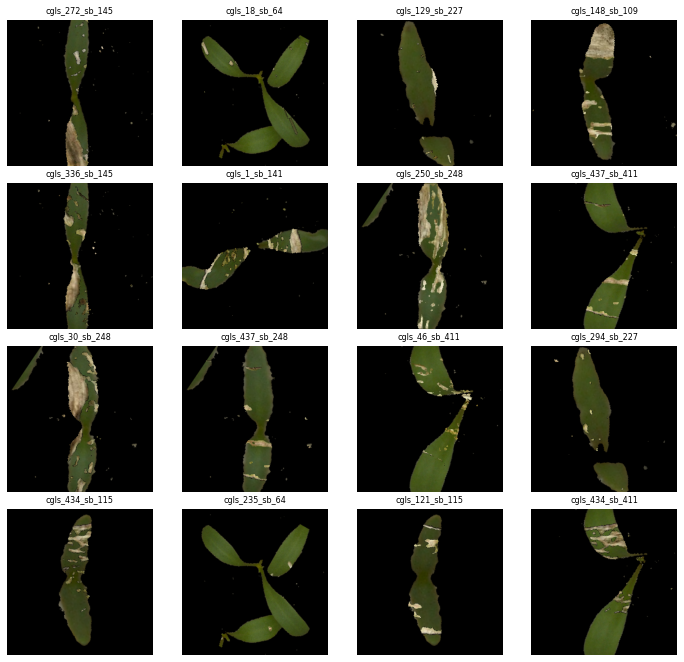

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12)) 

for i in range(16):

    fig.add_subplot(4,4,i+1, )
    plt.imshow(rand_gen_images[i])
    plt.title('{}'.format(rand_base_name[i]), fontsize=8, horizontalalignment='center')
    plt.axis('off')   
    plt.margins(x=0)

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

# Randomly inspect disease data

In [356]:
len(os.listdir(diseasePath))

513

In [334]:
rand_dis_images = []
rand_dis_base_name = []

for i in range(16):
    random_image = os.path.join(diseasePath, random.choice(os.listdir(diseasePath)))
    rand_img_name, _  = os.path.splitext(os.path.basename(random_image))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rand_dis_images.append(img)
    rand_dis_base_name.append(rand_img_name)


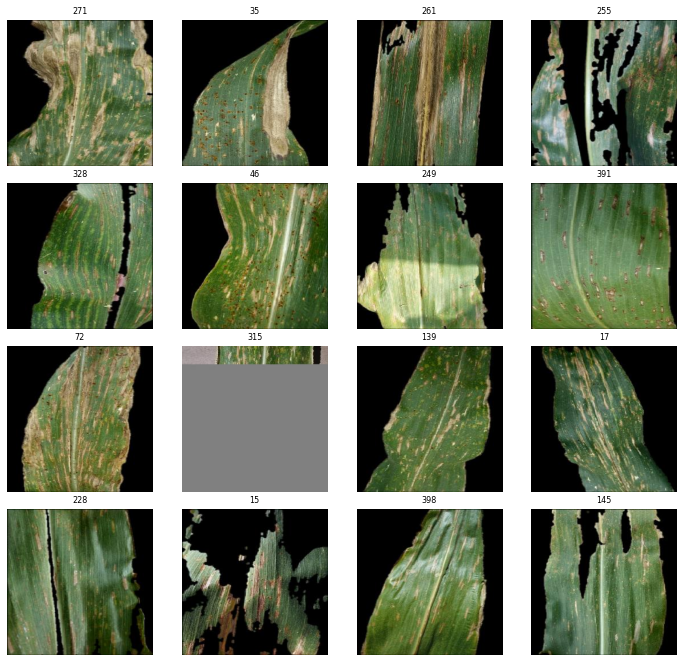

In [335]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12)) 

for i in range(16):

    fig.add_subplot(4,4,i+1, )
    plt.imshow(rand_dis_images[i])
    plt.title('{}'.format(rand_dis_base_name[i]), fontsize=8, horizontalalignment='center')
    plt.axis('off')   
    plt.margins(x=0)

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

# Randomly inspect sugar beet data

In [358]:
len(os.listdir(leafPath))

463

In [340]:
rand_sb_images = []
rand_sb_base_name = []

for i in range(16):
    random_image = os.path.join(leafPath, random.choice(os.listdir(leafPath)))
    rand_img_name, _  = os.path.splitext(os.path.basename(random_image))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rand_sb_images.append(img)
    rand_sb_base_name.append(rand_img_name)


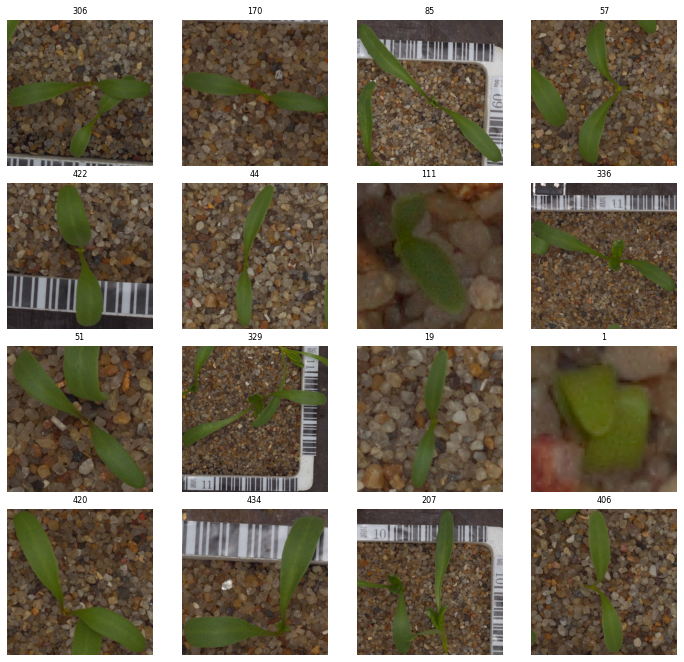

In [341]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12)) 

for i in range(16):

    fig.add_subplot(4,4,i+1, )
    plt.imshow(rand_sb_images[i])
    plt.title('{}'.format(rand_sb_base_name[i]), fontsize=8, horizontalalignment='center')
    plt.axis('off')   
    plt.margins(x=0)

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

# Randomly inspect non seg disease data

In [359]:
len(os.listdir(non_seg_dis_Path))

513

In [354]:
rand_non_seg_dis_images = []
rand_non_seg_dis_base_name = []

for i in range(16):
    random_image = os.path.join(non_seg_dis_Path, random.choice(os.listdir(non_seg_dis_Path)))
    rand_img_name, _  = os.path.splitext(os.path.basename(random_image))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rand_non_seg_dis_images.append(img)
    rand_non_seg_dis_base_name.append(rand_img_name)


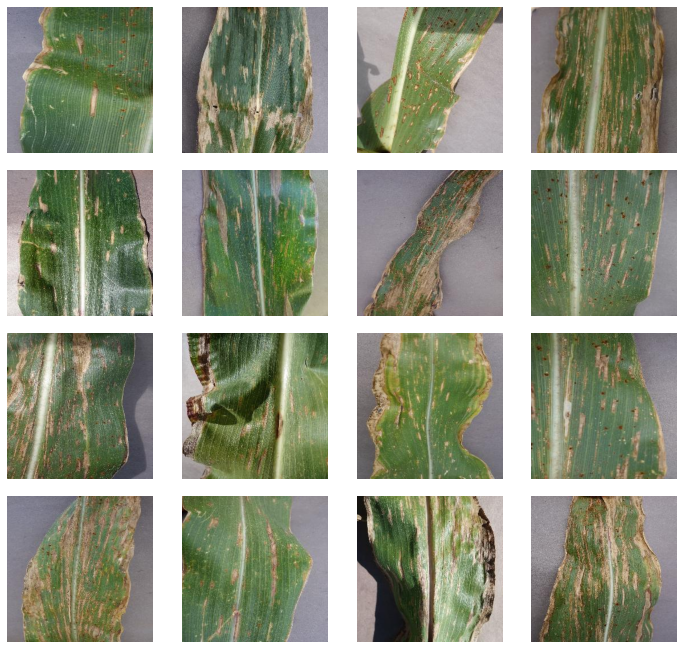

In [360]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12)) 

for i in range(16):

    fig.add_subplot(4,4,i+1, )
    plt.imshow(rand_non_seg_dis_images[i])
#     plt.title('{}'.format(rand_non_seg_dis_base_name[i]), fontsize=8, horizontalalignment='center')
    plt.axis('off')   
    plt.margins(x=0)

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.show()